In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from hamiltonian_generator import Hamiltonian
import qutip as qt
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
import numpy as np

def calculate_dephasing_rate(A):
    # Set parameters based on the system from file_context_0
    phi_ex = 0.2
    Ej = 30.19 
    Ec = 0.1
    sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
    # Use the provided A value
    optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

    sc = Hamiltonian(phi_ex, Ej, Ec, [3,2])
    H0 = qt.Qobj(sc.H)
    H_control = qt.Qobj(sc.H_control)
    # Set up the Floquet system
    initial_state, state_and_sigmax, get_projector = sc.setup_floquet_system(A, optimal_omega)

    # Get the noise operator from the system
    t = 0
    U, _, _ = state_and_sigmax(t)
    Ud = U.T.conj()
    U,_,_ = state_and_sigmax(0)
    initial_state = qt.Qobj(U[:,1])

    # Parameters for time evolution
    gamma = 1/1000
    t_list = np.linspace(0, 3000, 5000)  # Time points for simulation (up to 2000 ns)

    # Use the system's Hamiltonian
    H = [H0, [H_control, lambda t, args: A * np.cos(optimal_omega * t)]]  # Time-dependent Hamiltonian

    # Create collapse operators using the system's noise operator
    L = np.sqrt(gamma) * qt.Qobj(sc.s)
    c_ops = [L]

    # Time evolution using mesolve
    result = qt.mesolve(
        H,
        initial_state,
        t_list,
        c_ops,
        options=qt.Options(rtol=1e-10, atol=1e-10)
    )

    dims = H0.full().shape[0]
    avg_values = np.zeros((dims+1, len(t_list)))
    for i, t in enumerate(t_list):
        # Get the state at time t
        state_t = result.states[i]
        
        # Get the projector at time t
        U, sigmaxc,_ = state_and_sigmax(t)
        projectors = get_projector(U)
        
        # Calculate expectation values for all projectors
        for j in range(dims):
            avg_values[j, i] = qt.expect(projectors[j], state_t)
        avg_values[dims,i] = qt.expect(qt.Qobj(sigmaxc), state_t)

    # Fit exponential decay to extract relaxation time
    def relaxation_fit(t,  T1):
        return  1 - np.exp(-t / T1)

    # Initial guess for parameters
    p0 = [1000]  # occupation and steady_time guess
    # Fit the data
    popt, pcov = curve_fit(relaxation_fit, t_list, avg_values[0] , p0=p0)
    T1 = popt[0]

    def steady_state_fit(t, occupation, steady_time):
        return occupation *(1 -  np.exp(-t / steady_time))
    # Initial guess for parameters
    p0 = [1e-3, 1000]  # occupation and steady_time guess
    # Fit the data
    popt, pcov = curve_fit(steady_state_fit, t_list, avg_values[3] , p0=p0)
    occupation_1 = popt[0]
    steady_time_1 = popt[1]

    # Get the noise operator from the system
    t = 0
    U, _, _ = state_and_sigmax(t)
    Ud = U.T.conj()
    U,_,_ = state_and_sigmax(0)
    initial_state = qt.Qobj(U[:,0])

    # Use the system's Hamiltonian
    H = [H0, [H_control, lambda t, args: A * np.cos(optimal_omega * t)]]  # Time-dependent Hamiltonian

    # Create collapse operators using the system's noise operator
    L = np.sqrt(gamma) * qt.Qobj(sc.s)
    c_ops = [L]

    # Time evolution using mesolve
    result = qt.mesolve(
        H,
        initial_state,
        t_list,
        c_ops,
        options=qt.Options(rtol=1e-10, atol=1e-10)
    )

    avg_values = np.zeros((dims+1, len(t_list)))
    for i, t in enumerate(t_list):
        # Get the state at time t
        state_t = result.states[i]
        
        # Get the projector at time t
        U, sigmaxc,_ = state_and_sigmax(t)
        projectors = get_projector(U)
        
        # Calculate expectation values for all projectors
        for j in range(dims):
            avg_values[j, i] = qt.expect(projectors[j], state_t)
        avg_values[dims,i] = qt.expect(qt.Qobj(sigmaxc), state_t)

    # Initial guess for parameters
    p0 = [1e-3, 1000]  # occupation and steady_time guess

    # Fit the data
    popt, pcov = curve_fit(steady_state_fit, t_list, avg_values[2], p0=p0)
    occupation_0 = popt[0]
    steady_time_0 = popt[1]

    initial_state, state_and_sigmax, get_projector = sc.setup_floquet_system(A, optimal_omega)

    initial_state = qt.Qobj(initial_state)

    # Parameters for time evolution
    gamma = 1/1000
    t_list = np.linspace(0, 10000, 200000)  # Time points for simulation (up to 2000 ns)

    # Use the system's Hamiltonian
    H = [H0, [H_control, lambda t, args: A * np.cos(optimal_omega * t)]]  # Time-dependent Hamiltonian

    # Create collapse operators using the system's noise operator
    L = np.sqrt(gamma) * qt.Qobj(sc.s)
    c_ops = [L]

    # Time evolution using mesolve
    result = qt.mesolve(
        H,
        initial_state,
        t_list,
        c_ops,
        options=qt.Options(rtol=1e-10, atol=1e-10)
    )

    dims = H0.full().shape[0]
    avg_values = np.zeros((dims+1, len(t_list)))
    for i, t in enumerate(t_list):
        # Get the state at time t
        state_t = result.states[i]
        
        # Get the projector at time t
        U, sigmaxc,_ = state_and_sigmax(t)
        projectors = get_projector(U)
        
        # Calculate expectation values for all projectors
        for j in range(dims):
            avg_values[j, i] = qt.expect(projectors[j], state_t)
        avg_values[dims,i] = qt.expect(qt.Qobj(sigmaxc), state_t)

    # Fit exponential decay to extract relaxation time
    def T2fit(t,  T2,omega):
        return np.exp(-t / T2)*np.cos(omega*t)

    # Initial guess for parameters
    p0 = [1e6, -sc.omega_c + optimal_omega]  # occupation and steady_time guess

    # Set bounds for parameters: T2 cannot be larger than 1e7
    bounds = ([0, -np.inf], [1e8, np.inf])  # (lower_bounds, upper_bounds)

    # Fit the data
    popt, pcov = curve_fit(T2fit, t_list[:40000], avg_values[-1][:40000], p0=p0, bounds=bounds)
    T2_fit = popt[0]
    omega_fit = popt[1]

    return (1/T2_fit - 1/T1/2)

def safe_calc(A_val):
    try:
        result = calculate_dephasing_rate(A_val)
        return result, None, A_val
    except Exception as e:
        return None, str(e), A_val

# Create an array of A values from 1e-4*2*pi to 5e-3*2*pi with 20 points
A_values = np.linspace(1e-4 * 2 * np.pi, 5e-3 * 2 * np.pi, 20)

# Use joblib to parallelize the calculation and capture errors for each A value
results = Parallel(n_jobs=30)(delayed(safe_calc)(A_val) for A_val in A_values)
for res, err, A_val in results:
    if err:
        print(f"Error for A = {A_val}: {err}")
    else:
        print(f"Success for A = {A_val}: result = {res}")

 /home/yunwei/.conda/envs/yunwei/lib/python3.11/site-packages/qutip/solver/options.py: 16FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
 /home/yunwei/.conda/envs/yunwei/lib/python3.11/site-packages/qutip/solver/options.py: 16FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
 /home/yunwei/.conda/envs/yunwei/lib/python3.11/site-packages/qutip/solver/options.py: 16FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
 /home/yunwei/.conda/envs/yunwei/lib/python3.11/site-packages/qutip/solver/options.py: 16FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
 /home/yunwei/.conda/envs/yunwei/lib/python3.11/site-packages/qutip/solver/options.py: 16FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
 /home/yunwei/.conda/envs

Success for A = 0.0006283185307179586: result = 2.671307524103205e-06
Success for A = 0.0022487189520432205: result = 1.1900872414487128e-06
Success for A = 0.0038691193733684827: result = 9.255219865033203e-07
Success for A = 0.005489519794693744: result = 8.269707570705108e-07
Success for A = 0.007109920216019006: result = 7.84009838557495e-07
Success for A = 0.008730320637344267: result = 7.835104080581995e-07
Success for A = 0.01035072105866953: result = 8.025796716080047e-07
Success for A = 0.011971121479994792: result = 8.330274140897813e-07
Success for A = 0.013591521901320054: result = 8.736650754380738e-07
Success for A = 0.015211922322645316: result = 9.201143224847569e-07
Success for A = 0.016832322743970576: result = 9.691102982351504e-07
Success for A = 0.01845272316529584: result = 1.0213864649141104e-06
Success for A = 0.0200731235866211: result = 1.0769919741104429e-06
Success for A = 0.021693524007946365: result = 1.1352617756448757e-06
Success for A = 0.02331392442927

In [4]:
from hamiltonian_generator import Hamiltonian
import qutip as qt

def get_noise_operator(A):
    phi_ex = 0.2
    Ej = 30.19 
    Ec = 0.1
    
    sc = Hamiltonian(phi_ex, Ej, Ec, [5,4])
    optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi
    sc = Hamiltonian(phi_ex, Ej, Ec, [3,2])
    initial_state, state_and_sigmax, get_projector = sc.setup_floquet_system(A, optimal_omega)
    
    t = 0
    U, _, _ = state_and_sigmax(t)
    Ud = U.T.conj()
    # Work with a fresh copy of noise every time
    noise1 = Ud @ sc.s @ U
    # Take the real part if necessary
    
    return noise1
def numerical_dephasing(A):
    noise = get_noise_operator(A)
    return 1e-3*np.abs(noise[1,1] - noise[0,0])**2/2 + 1e-3*np.abs(noise[3,1])**2/2 + 1e-3*np.abs(noise[2,0])**2/2

# Use joblib to parallelize the calculation of dephasing rate for each A value
results1 = Parallel(n_jobs=-1)(delayed(numerical_dephasing)(A_val) for A_val in A_values)

results1



[np.float64(2.7041141315213714e-06),
 np.float64(1.1945783271979332e-06),
 np.float64(9.248463699355448e-07),
 np.float64(8.22833765519722e-07),
 np.float64(7.811058270330623e-07),
 np.float64(7.794704043961904e-07),
 np.float64(7.944413925268206e-07),
 np.float64(8.238587489485855e-07),
 np.float64(8.622532079509635e-07),
 np.float64(9.020849408062291e-07),
 np.float64(9.554399747788575e-07),
 np.float64(1.001592724357309e-06),
 np.float64(1.0586824777663215e-06),
 np.float64(1.1089952607524048e-06),
 np.float64(1.1678627423216671e-06),
 np.float64(1.2269292462712103e-06),
 np.float64(1.2857273989289682e-06),
 np.float64(1.3508722652094375e-06),
 np.float64(1.406250557457518e-06),
 np.float64(1.4811897769501053e-06)]

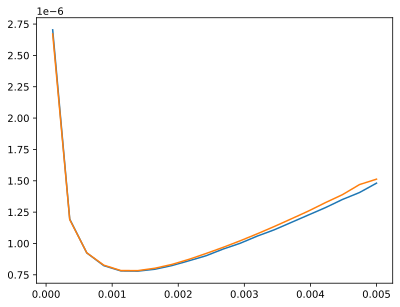

In [11]:

plt.plot(A_values/2/np.pi, results1, label='Numerical Dephasing')
plt.plot(A_values/2/np.pi, np.array(results)[:,0], label='simulation Dephasing')
np.savez("white.npz", A_values=A_values, results1=np.array(results1), simulation=np.array(results)[:, 0])

In [14]:
data = np.load("white.npz", allow_pickle=True)
print("A_values:", data["A_values"])
print("results1:", data["results1"])
print("simulation:", data["simulation"])

A_values: [0.00062832 0.00224872 0.00386912 0.00548952 0.00710992 0.00873032
 0.01035072 0.01197112 0.01359152 0.01521192 0.01683232 0.01845272
 0.02007312 0.02169352 0.02331392 0.02493432 0.02655473 0.02817513
 0.02979553 0.03141593]
results1: [2.70411413e-06 1.19457833e-06 9.24846370e-07 8.22833766e-07
 7.81105827e-07 7.79470404e-07 7.94441393e-07 8.23858749e-07
 8.62253208e-07 9.02084941e-07 9.55439975e-07 1.00159272e-06
 1.05868248e-06 1.10899526e-06 1.16786274e-06 1.22692925e-06
 1.28572740e-06 1.35087227e-06 1.40625056e-06 1.48118978e-06]
simulation: [np.float64(2.671307524103205e-06) np.float64(1.1900872414487128e-06)
 np.float64(9.255219865033203e-07) np.float64(8.269707570705108e-07)
 np.float64(7.84009838557495e-07) np.float64(7.835104080581995e-07)
 np.float64(8.025796716080047e-07) np.float64(8.330274140897813e-07)
 np.float64(8.736650754380738e-07) np.float64(9.201143224847569e-07)
 np.float64(9.691102982351504e-07) np.float64(1.0213864649141104e-06)
 np.float64(1.07699197